# UTKFace

- consists of 20k+ face images in the wild (only single face in one image)
- provides the correspondingly aligned and cropped faces
- provides the corresponding landmarks (68 points)
- images are labelled by age, gender, and ethnicity

- The labels of each face image is embedded in the file name, formated like [age]_[gender]_[race]_[date&time].jpg

- [age] is an integer from 0 to 116, indicating the age
- [gender] is either 0 (male) or 1 (female)
- [race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
- [date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

In [ ]:
#install kaggle
!pip install -q kaggle
from google.colab import files
files.upload()
#create a kaggle folder
! mkdir ~/.kaggle
# copy the kaggle.json to folder created
! cp kaggle.json ~/.kaggle/
# permission for the json to act
! chmod 600 ~/.kaggle/kaggle.json
# to list all dataset in kaggle
! kaggle datasets list

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download -d jangedoo/utkface-new

In [3]:
! unzip utkface-new

Archive:  utkface-new.zip
replace UTKFace/100_0_0_20170112213500903.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [ ]:
all_images = []

age_labels = []
gender_labels = []
race_labels = []

#dataset_directory = '/content/UTKFace'
dataset_directory = '/content/crop_part1'


for i , item in enumerate(os.listdir(dataset_directory)):

    try:
      labels = os.path.splitext(item)[0]
      age, gender, race, _ = labels.split('_')
      img = cv2.imread(os.path.join(dataset_directory, item))
      img = cv2.resize(img, (100, 100))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      all_images.append(img)

    except Exception as ex:
        continue

    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)


    if i % 100 == 0:
        print("[INFO]: {}/{} processed".format(i, len(os.listdir(dataset_directory))))

all_images = np.array(all_images).astype('uint8')/255.0
all_images = all_images/255.0

age_labels = np.array(age_labels)
gender_labels = np.array(gender_labels)
race_labels = np.array(race_labels)

#sanity cheak
print('age_labels.shape(after_preprocessing)', age_labels.shape ,'number_age :' ,len(set(age_labels)))
print('gender_labels.shape(after_preprocessing)', gender_labels.shape, 'number_gender :' ,len(set(gender_labels)))
print('race_labels.shape(after_preprocessing)', race_labels.shape, 'number_race :' ,len(set(race_labels)))

# One Hot encoding
genderLB = LabelBinarizer()
raceLB = LabelBinarizer()

gender_labels = genderLB.fit_transform(gender_labels)
race_labels = raceLB.fit_transform(race_labels)

#train-test-validation split

trainX, testX, train_ageY, test_ageY, train_genderY, test_genderY, train_raceY, test_raceY= train_test_split(all_images, age_labels,
                         gender_labels, race_labels,  test_size=0.2)

trainX, validX, train_ageY, valid_ageY, train_genderY, valid_genderY, train_raceY, valid_raceY = train_test_split(trainX, train_ageY,
                         train_genderY, train_raceY,  test_size=0.1)
# sanity cheak
print('trainX.shape', trainX.shape)
print('testX.shape', testX.shape)
print('validX.shape', validX.shape)


In [15]:
print(age_labels)

['62' '21' '24' ... '27' '52' '52']


In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
from tensorflow.keras import layers, models

class UKTFaceNet():

    @staticmethod
    def build(number_race):

        # input
        input_layer = layers.Input((100, 100, 3))
        
        # age net
        x = layers.Conv2D(32,(3,3), activation= "relu", padding="same")(input_layer)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPool2D((3, 3))(x)
        x = layers.Dropout(0.25)(x)

        x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPool2D((2, 2))(x)
        x = layers.Dropout(0.25)(x)

        x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPool2D((2, 2))(x)
        x = layers.Dropout(0.25)(x)

        x = layers.Flatten()(x)
        x = layers.Dense(256, activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)
        x = layers.Dense(1)(x)
        age_net = layers.Activation("linear", name="age_output")(x)

        # gender net
        y = layers.Conv2D(16, (3, 3), activation="relu",
                          padding="same")(input_layer)
        y = layers.BatchNormalization()(y)
        y = layers.MaxPool2D((3, 3))(y)
        y = layers.Dropout(0.25)(y)

        y = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(y)
        y = layers.BatchNormalization()(y)
        y = layers.MaxPool2D((2, 2))(y)
        y = layers.Dropout(0.25)(y)

        y = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(y)
        y = layers.BatchNormalization()(y)
        y = layers.MaxPool2D((2, 2))(y)
        y = layers.Dropout(0.25)(y)

        y = layers.Flatten()(y)
        y = layers.Dense(256, activation="relu")(y)
        y = layers.Dropout(0.5)(y)
        y = layers.BatchNormalization()(y)
        y = layers.Dense(1)(y)
        gender_net = layers.Activation("sigmoid", name="gender_output")(y)
        
        # race net
        z = layers.Conv2D(16, (3, 3), activation="relu",
                          padding="same")(input_layer)
        z = layers.BatchNormalization()(z)
        z = layers.MaxPool2D((3, 3))(z)
        z = layers.Dropout(0.25)(z)

        z = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(z)
        z = layers.BatchNormalization()(z)
        z = layers.MaxPool2D((2, 2))(z)
        z = layers.Dropout(0.25)(z)

        z = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(z)
        z = layers.BatchNormalization()(z)
        z = layers.MaxPool2D((2, 2))(z)
        z = layers.Dropout(0.25)(z)

        z = layers.Flatten()(z)
        z = layers.Dense(256, activation="relu")(z)
        z = layers.Dropout(0.5)(z)
        z = layers.BatchNormalization()(z)
        z = layers.Dense(number_race)(z)
        race_net = layers.Activation("softmax", name="race_output")(z)

        net = models.Model(inputs = input_layer,
                           outputs = [age_net, gender_net, race_net],
                           name = "UKTFaceNet")
        
        return net


In [ ]:
fnet = UKTFaceNet()
net = fnet.build(5)

#net.summary()


losses = {
        "age_output" : "mse",
        "gender_output" : "binary_crossentropy",
        "race_output" : "categorical_crossentropy"
        }

epoch = 20
loss_weights = {"age_output": 1.0, "gender_output": 1.0, "race_output": 1.0 }
metrics = {"age_output" :"mae", "gender_output" :"accuracy", "race_output" :"accuracy"}

net.compile(optimizer="adam",
            loss = losses, 
            loss_weights = loss_weights,
            metrics = metrics)
trainX, testX, train_ageY, test_ageY, train_genderY, test_genderY, train_raceY, test_raceY= train_test_split(all_images, age_labels,
                         gender_labels, race_labels,  test_size=0.2)

trainX, validX, train_ageY, valid_ageY, train_genderY, valid_genderY, train_raceY, valid_raceY = train_test_split(trainX, train_ageY,
                         train_genderY, train_raceY,  test_size=0.1)
H = net.fit(x=trainX,
            y = {"age_output": train_ageY, "gender_output": train_genderY,"race_output" : train_raceY },
            validation_data=(validX,
                             {"age_output": valid_ageY, "gender_output": valid_genderY, "race_output" :valid_raceY}),
            epochs=epoch)


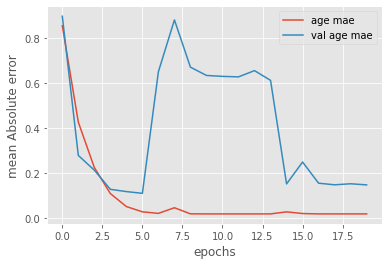

In [11]:
# age acuuracy
plt.plot(H.history["age_output_mae"], label = "age mae")
plt.plot(H.history["val_age_output_mae"], label="val age mae")
plt.xlabel("epochs")
plt.ylabel("mean Absolute error")
plt.legend()
plt.show()
plt.close()

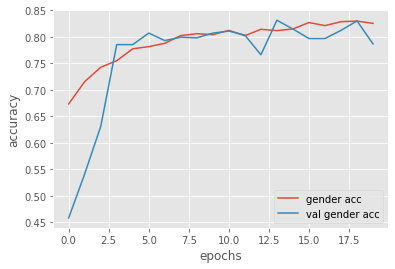

In [12]:
# gender acuuracy
plt.plot(H.history["gender_output_accuracy"], label = "gender acc")
plt.plot(H.history["val_gender_output_accuracy"], label="val gender acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()
plt.close()

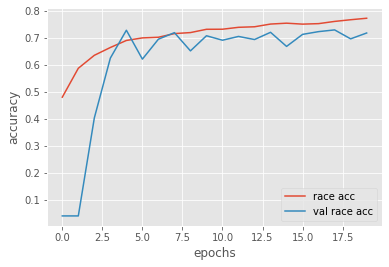

In [13]:
# race acuuracy
plt.plot(H.history["race_output_accuracy"], label = "race acc")
plt.plot(H.history["val_race_output_accuracy"], label="val race acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()
plt.close()



- Evaluate our model on the test set ;)

In [14]:
predicted_age_label, predicted_gender_label, predicted_race_label = net.predict(testX)


In [16]:
predicted_age_label

array([[0.01007277],
       [0.01002446],
       [0.01004118],
       ...,
       [0.01005481],
       [0.01012836],
       [0.01004413]], dtype=float32)

In [ ]:
test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
samples = 0
images, age_true, race_true, gender_true = [], [], [], []
for test_batch in test_generator:
    image = test_batch[0]
    labels = test_batch[1]
    
    images.extend(image)
    age_true.extend(labels[0])
    race_true.extend(labels[1])
    gender_true.extend(labels[2])
    
age_true = np.array(age_true)
race_true = np.array(race_true)
gender_true = np.array(gender_true)
race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)
age_true = age_true * data_generator.max_age
age_pred = age_pred * data_generator.max_age

In [17]:
test_ageY

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])